<a href="https://colab.research.google.com/github/DyatlovaA/cv-tf/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22cv_tf_pr1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №1 на тему "Классификация изображений машин и самолетов с использованием нейронных сетей"

Выполнили студенты Сухоруков М.С и Дятлова А.А., гр. 6.

## Цель работы

Целью данной практической работы является создание и обучение нейронной сети, способной классифицировать изображения на два класса: машины и самолеты. Мы будем использовать датасет CIFAR-10, который содержит изображения различных объектов, включая автомобили и самолеты. В процессе работы мы реализуем сверточную нейронную сеть (CNN) с использованием библиотеки TensorFlow и оценим её производительность на тестовых данных. Также используем VGG19 для классификации изображений с помощью подхода transfer learning .

## Введение

В данной работе решается задача классификации изображений на два класса: машины и самолеты. Для этого используется датасет CIFAR-10, который содержит 60 000 цветных изображений размером 32x32 пикселя, разделенных на 10 классов. Мы сосредоточимся на двух классах: автомобили (класс 1) и самолеты (класс 0).  Модель будет использовать VGG19 для извлечения признаков из изображений и обучать новые слои для классификации между этими двумя классами.

Для решения задачи будет реализована сверточная нейронная сеть (CNN), которая является эффективным инструментом для работы с изображениями. CNN автоматически извлекает признаки из изображений, что позволяет достичь высокой точности классификации.



#Установим библиотеки:

#Предобработка данных

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cifar-10

401 - Unauthorized - Unauthenticated


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

Загрузка данных CIFAR-10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Нормализация данных (приведение значений пикселей к диапазону [0, 1])

In [ ]:
train_images, test_images = train_images / 255.0, test_images / 255.0

Фильтрация данных для выбора только машин (automobile) и самолетов (airplane)

In [ ]:
def filter_classes(images, labels, class1, class2):
    mask = (labels == class1) | (labels == class2)
    return images[mask.squeeze()], labels[mask.squeeze()]

Классы: airplane (0), automobile (1)

In [ ]:
train_images, train_labels = filter_classes(train_images, train_labels, 0, 1)
test_images, test_labels = filter_classes(test_images, test_labels, 0, 1)

Преобразование меток в бинарные (0 и 1)

In [ ]:
train_labels = np.where(train_labels == 0, 0, 1)
test_labels = np.where(test_labels == 0, 0, 1)

Преобразование меток в одномерный массив

In [ ]:
 train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

Функция для отображения изображений

In [ ]:
def plot_images(images, labels, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])  # Теперь labels[i] будет скаляром
    plt.show()

Визуализация данных (Отображение первых 25 изображений)

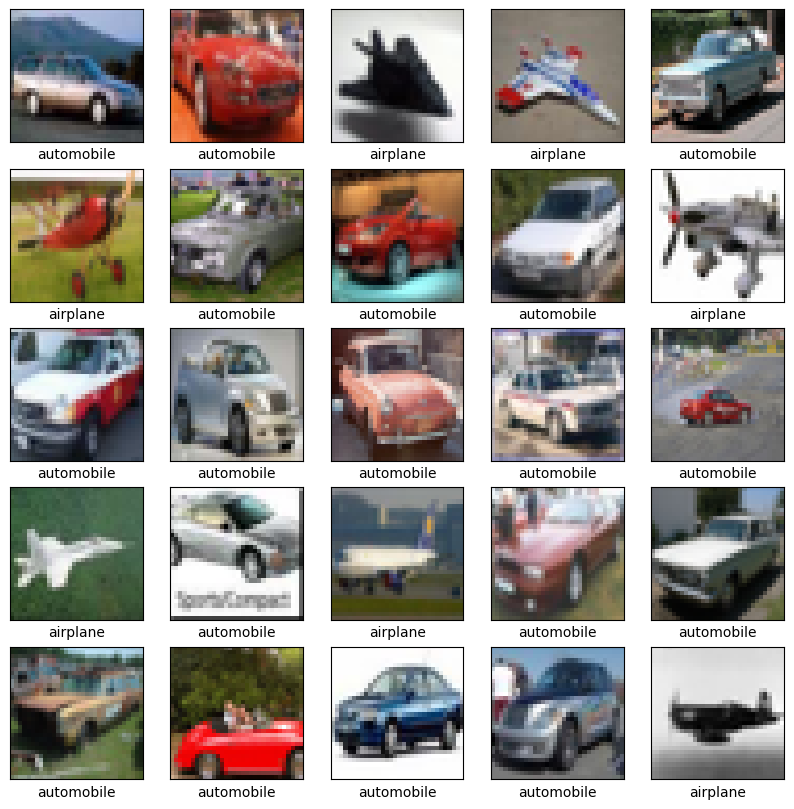

In [ ]:
plot_images(train_images, train_labels, ['airplane', 'automobile'])

Преобразование данных в tf.data.Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

Разделение на батчи и перемешивание

In [ ]:
batch_size = 32
train_dataset = train_dataset.shuffle(len(train_images)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Оптимизация производительности

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Построение модели

Импорт необходимых библиотек


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

Высота и ширина изображений

In [ ]:
img_height = 32  # Высота изображений CIFAR-10
img_width = 32   # Ширина изображений CIFAR-10

Создание модели

In [ ]:
model = Sequential([
    layers.Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(['airplane', 'automobile']), activation='softmax')  # 2 класса
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Вывод структуры модели

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 885,666 (3.38 MB)

 Trainable params: 885,666 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

Компиляция модели

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Обучение модели


In [ ]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.5057 - sparse_categorical_accuracy: 0.7249 - val_loss: 0.2124 - val_sparse_categorical_accuracy: 0.9150
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2177 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.1844 - val_sparse_categorical_accuracy: 0.9195
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1591 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.1480 - val_sparse_categorical_accuracy: 0.9395
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1200 - sparse_categorical_accuracy: 0.9547 - val_loss: 0.1474 - val_sparse_categorical_accuracy: 0.9465
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.1868 - val_sparse_categorical_accuracy: 0.9285
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0851 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.1235 - val_sparse_categorical_accuracy: 0.9530
Ep

Сохранение модели

In [ ]:
model.save('cnn_model.keras')

Функция для построения матрицы ошибок

In [ ]:
def tf_confusion_matrix(model, data_loader, classes):
    matrix = tf.zeros((len(classes), len(classes)), dtype=tf.int32)

    for inputs, labels in data_loader:
        outputs = model.predict(inputs)
        true_class = labels
        predict_class = tf.argmax(outputs, axis=1)
        for t, p in zip(true_class, predict_class):
            matrix = tf.tensor_scatter_nd_add(matrix, [[t, p]], [1])

    print(matrix)

Построение матрицы ошибок

In [ ]:
tf_confusion_matrix(model, test_dataset, ['airplane', 'automobile'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

#Tрансферное обучение

Используем предобученную модель VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

Параметры для VGG19

In [ ]:
img_height = 32  # VGG19 требует изображения размером 224x224
img_width = 32

Изменение размера изображений для VGG19

In [ ]:
train_images_resized = tf.image.resize(train_images, [img_height, img_width])
test_images_resized = tf.image.resize(test_images, [img_height, img_width])

Преобразование данных в tf.data.Dataset для VGG19

In [ ]:
train_dataset_vgg = tf.data.Dataset.from_tensor_slices((train_images_resized, train_labels))
test_dataset_vgg = tf.data.Dataset.from_tensor_slices((test_images_resized, test_labels))

Разделение на батчи и перемешивание

In [ ]:
batch_size = 16
train_dataset_vgg = train_dataset_vgg.shuffle(len(train_images_resized)).batch(batch_size)
test_dataset_vgg = test_dataset_vgg.batch(batch_size)

Оптимизация производительности

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_vgg = train_dataset_vgg.prefetch(buffer_size=AUTOTUNE)
test_dataset_vgg = test_dataset_vgg.prefetch(buffer_size=AUTOTUNE)

Создание модели VGG19

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Замораживаем слои VGG19

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Создаем новую модель на основе VGG19

In [ ]:
model_vgg = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 класса: airplane и automobile
])

Компиляция модели

In [ ]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Вывод структуры модели

In [ ]:
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,812,610 (79.39 MB)

 Trainable params: 788,226 (3.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Обучение модели VGG19

In [ ]:
history_vgg = model_vgg.fit(
    train_dataset_vgg,
    validation_data=test_dataset_vgg,
    epochs=5
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8255 - loss: 0.4059 - val_accuracy: 0.8995 - val_loss: 0.2482
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8877 - loss: 0.2724 - val_accuracy: 0.9075 - val_loss: 0.2295
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8965 - loss: 0.2476 - val_accuracy: 0.8920 - val_loss: 0.2736
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9077 - loss: 0.2335 - val_accuracy: 0.9085 - val_loss: 0.2191
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9131 - loss: 0.2266 - val_accuracy: 0.9190 - val_loss: 0.2110


In [ ]:
model_vgg.save('vgg_model.keras')

Оптимизация производительности

In [ ]:
tf_confusion_matrix(model_vgg, test_dataset_vgg, ['airplane', 'automobile'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

Извлечение значений потерь и точности

In [ ]:
import matplotlib.pyplot as plt


loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc_values = history.history['sparse_categorical_accuracy']
val_acc_values = history.history['val_sparse_categorical_accuracy']

epochs = range(1, len(loss_values) + 1)


График потери

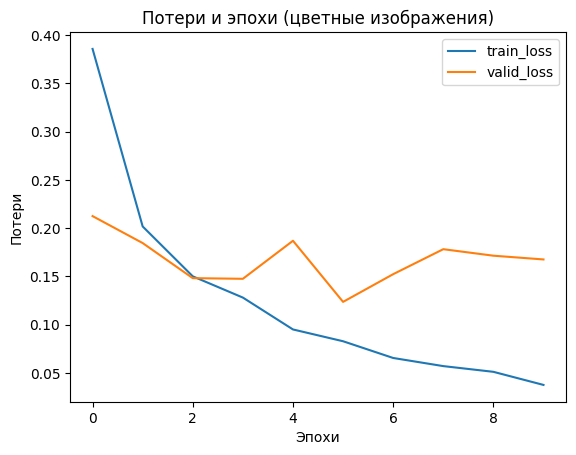

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='valid_loss')
plt.title('Потери и эпохи (цветные изображения)')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

График точности

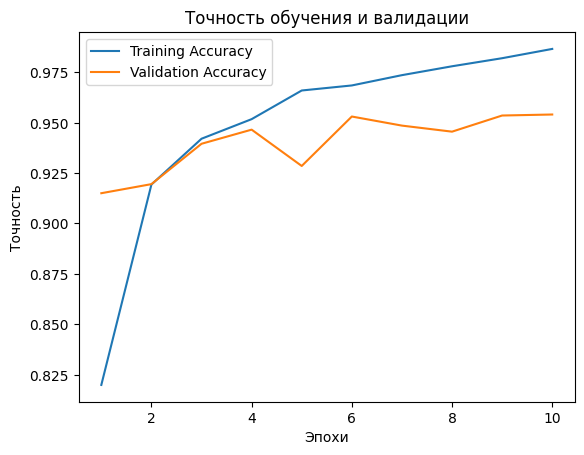

In [ ]:
# График точности
plt.plot(epochs, acc_values, label='Training Accuracy')
plt.plot(epochs, val_acc_values, label='Validation Accuracy')
plt.title('Точность обучения и валидации')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.show()

Определение скорости модели

In [ ]:
import time

# Измерение скорости модели для цветных изображений
start_time = time.time()
model.fit(train_dataset, validation_data=test_dataset, epochs=1)
end_time = time.time()

elapsed_time = end_time - start_time
fps_color = len(train_dataset) / elapsed_time
print(f"FPS для цветных изображений: {fps_color:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.1664 - val_sparse_categorical_accuracy: 0.9620
FPS для цветных изображений: 164.97


#Анализ Ч/Б изображений

Преобразование цветных изображений в оттенки серого

In [ ]:
train_images_gray = tf.image.rgb_to_grayscale(train_images)
test_images_gray = tf.image.rgb_to_grayscale(test_images)

Обновление формы данных для ЧБ изображений

In [ ]:
train_images_gray = train_images_gray.numpy().reshape(-1, 32, 32, 1)
test_images_gray = test_images_gray.numpy().reshape(-1, 32, 32, 1)

Преобразование данных в tf.data.Dataset для ЧБ изображений

In [ ]:
train_dataset_gray = tf.data.Dataset.from_tensor_slices((train_images_gray, train_labels))
test_dataset_gray = tf.data.Dataset.from_tensor_slices((test_images_gray, test_labels))

Разделение на батчи и перемешивание

In [ ]:
train_dataset_gray = train_dataset_gray.shuffle(len(train_images_gray)).batch(batch_size)
test_dataset_gray = test_dataset_gray.batch(batch_size)

Оптимизация производительности

In [ ]:
train_dataset_gray = train_dataset_gray.prefetch(buffer_size=AUTOTUNE)
test_dataset_gray = test_dataset_gray.prefetch(buffer_size=AUTOTUNE)

Построение модели для ЧБ изображений

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Построение модели для ЧБ изображений
model_gray = Sequential([
    Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(32, 32, 1)),  # Один канал для ЧБ
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(['airplane', 'automobile']), activation='softmax')  # 2 класса
])

Вывод структуры модели и компиляция

In [ ]:
model_gray.summary()

model_gray.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 885,378 (3.38 MB)

 Trainable params: 885,378 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Компиляция модели (используем SparseCategoricalCrossentropy)
model_gray.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

Обучение модели на ЧБ изображениях

In [ ]:
epochs = 10
history_gray = model_gray.fit(
    train_dataset_gray,
    validation_data=test_dataset_gray,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4920 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.2390 - val_sparse_categorical_accuracy: 0.9045
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2137 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.8485
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1855 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.1684 - val_sparse_categorical_accuracy: 0.9320
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1386 - val_sparse_categorical_accuracy: 0.9495
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.1326 - val_sparse_categorical_accuracy: 0.9505
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1392 - val_sparse_categorical_accuracy: 0.9515
Epoc

Сохранение модели

In [ ]:
model_gray.save('cnn_model_gray.keras')

Функция для матрицы ошибок

In [ ]:
def tf_confusion_matrix(model, data_loader, classes):
    matrix = tf.zeros((len(classes), len(classes)), dtype=tf.int32)

    for inputs, labels in data_loader:
        outputs = model.predict(inputs)
        true_class = labels
        predict_class = tf.argmax(outputs, axis=1)
        for t, p in zip(true_class, predict_class):
            matrix = tf.tensor_scatter_nd_add(matrix, [[t, p]], [1])

    print(matrix)

Построение матрицы

In [ ]:
print("Матрица ошибок для ЧБ изображений:")
tf_confusion_matrix(model_gray, test_dataset_gray, ['airplane', 'automobile'])

Матрица ошибок для ЧБ изображений:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

Построение графиков потерь и точности для ЧБ изображений

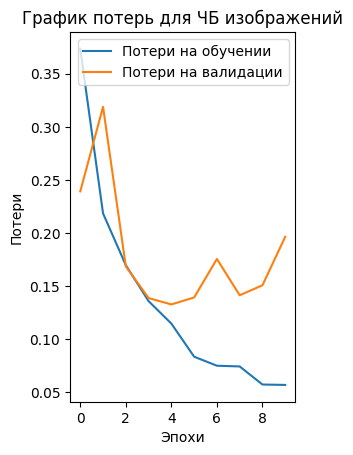

In [ ]:
# График потерь
plt.subplot(1, 2, 1)
plt.plot(history_gray.history['loss'], label='Потери на обучении')
plt.plot(history_gray.history['val_loss'], label='Потери на валидации')
plt.title('График потерь для ЧБ изображений')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()


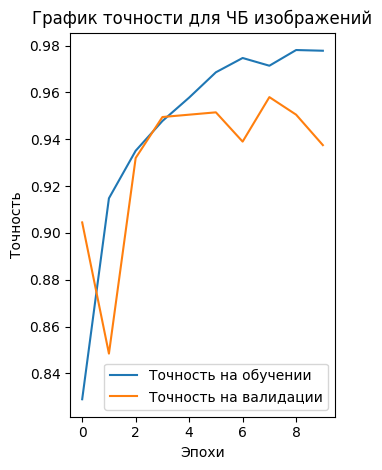

In [ ]:
# График точности
plt.subplot(1, 2, 2)
plt.plot(history_gray.history['sparse_categorical_accuracy'], label='Точность на обучении')
plt.plot(history_gray.history['val_sparse_categorical_accuracy'], label='Точность на валидации')
plt.title('График точности для ЧБ изображений')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Измерение скорости модели для ЧБ изображений
start_time = time.time()
model_gray.fit(train_dataset_gray, validation_data=test_dataset_gray, epochs=1)
end_time = time.time()

elapsed_time = end_time - start_time
fps_gray = len(train_dataset_gray) / elapsed_time
print(f"FPS для ЧБ изображений: {fps_gray:.2f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.2621 - val_sparse_categorical_accuracy: 0.9460
FPS для ЧБ изображений: 245.23


# Изображения с сайтов

In [ ]:
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Функция для загрузки и обработки изображения

In [ ]:
# Функция для загрузки и обработки изображения
def load_and_preprocess_image(url, img_height=32, img_width=32):
    # Загрузка изображения по URL
    response = requests.get(url, stream=True)
    response.raise_for_status()

    # Открытие изображения с помощью Pillow
    img = Image.open(response.raw)

    # Преобразование изображения в цветной формат (RGB)
    img_color = img.convert('RGB')
    img_color = img_color.resize((img_height, img_width))
    img_color_array = np.array(img_color) / 255.0  # Нормализация
    img_color_array = np.expand_dims(img_color_array, axis=0)  # Добавляем batch_size

    # Преобразование изображения в черно-белый формат (grayscale)
    img_gray = img.convert('L')  # 'L' — режим оттенков серого
    img_gray = img_gray.resize((img_height, img_width))
    img_gray_array = np.array(img_gray) / 255.0  # Нормализация
    img_gray_array = np.expand_dims(img_gray_array, axis=0)  # Добавляем batch_size
    img_gray_array = np.expand_dims(img_gray_array, axis=-1)  # Добавляем канал

    return img_color, img_gray, img_color_array, img_gray_array

 Функция для анализа изображения моделью

In [ ]:
# Функция для анализа изображения моделью
def analyze_image(model_color, model_gray, url):
    # Загрузка и предобработка изображения
    img_color, img_gray, img_color_array, img_gray_array = load_and_preprocess_image(url)

    # Визуализация загруженного изображения
    plt.figure(figsize=(10, 5))

    # Цветное изображение
    plt.subplot(1, 2, 1)
    plt.imshow(img_color)
    plt.title("Цветное изображение")
    plt.axis('off')

    # Черно-белое изображение
    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Черно-белое изображение")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Предсказание для цветного изображения
    predictions_color = model_color.predict(img_color_array)
    predicted_class_color = np.argmax(predictions_color, axis=1)

    # Предсказание для ЧБ изображения
    predictions_gray = model_gray.predict(img_gray_array)
    predicted_class_gray = np.argmax(predictions_gray, axis=1)

    # Возвращаем результат
    class_names = ['airplane', 'automobile']  # Классы модели
    return {
        "color": class_names[predicted_class_color[0]],
        "gray": class_names[predicted_class_gray[0]]
    }

Введите количество изображений: 4
Введите URL изображения 1: https://avatars.mds.yandex.net/i?id=6c8ecfcc2757d672c24584be6709308c_l-10702734-images-thumbs&n=13
Введите URL изображения 2: https://trk7.ru/upload/iblock/69c/d1wuu39nawe2px52zke5hx7ed9s32pf0.jpg
Введите URL изображения 3: https://img.rosbalt.ru/photobank/c/b/9/e/JD84mHpt-1280.jpg
Введите URL изображения 4: https://avatars.mds.yandex.net/i?id=17c3959676b98a135e00adb68fd4856d_l-4550834-images-thumbs&n=13

Анализ изображения 1:


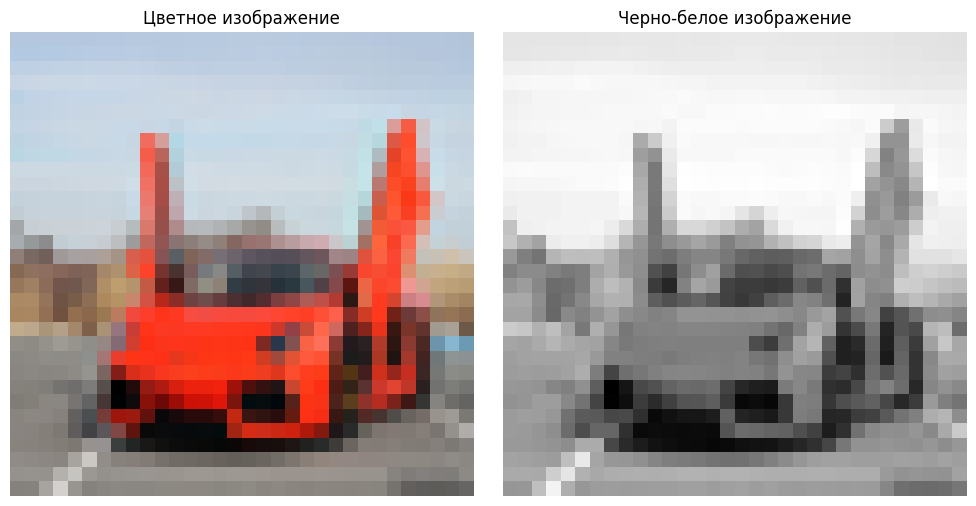

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Модель для цветных изображений предсказывает: automobile
Модель для ЧБ изображений предсказывает: automobile

Анализ изображения 2:


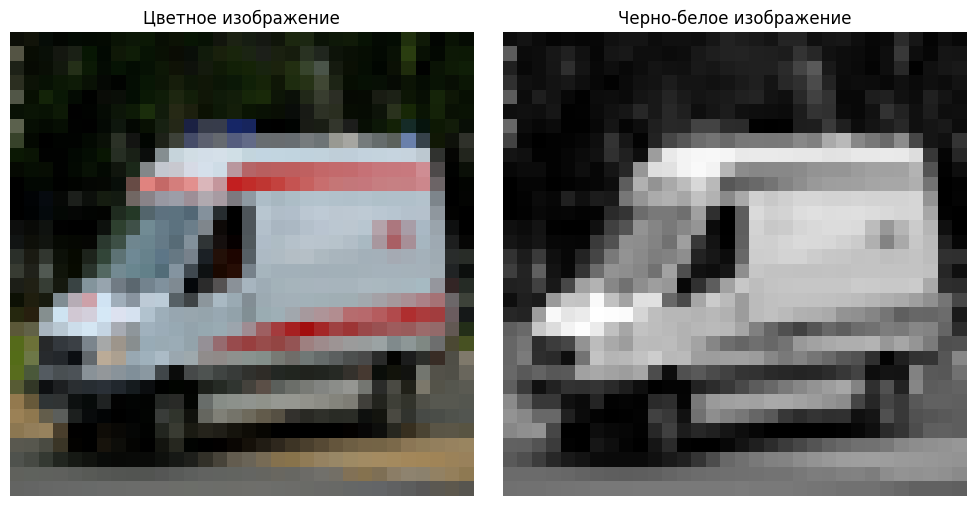

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Модель для цветных изображений предсказывает: automobile
Модель для ЧБ изображений предсказывает: automobile

Анализ изображения 3:


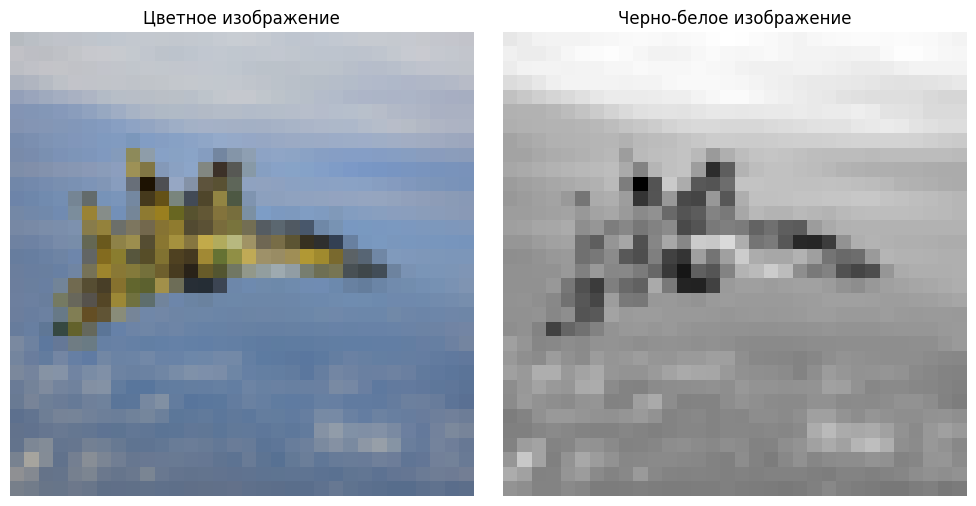

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Модель для цветных изображений предсказывает: airplane
Модель для ЧБ изображений предсказывает: airplane

Анализ изображения 4:


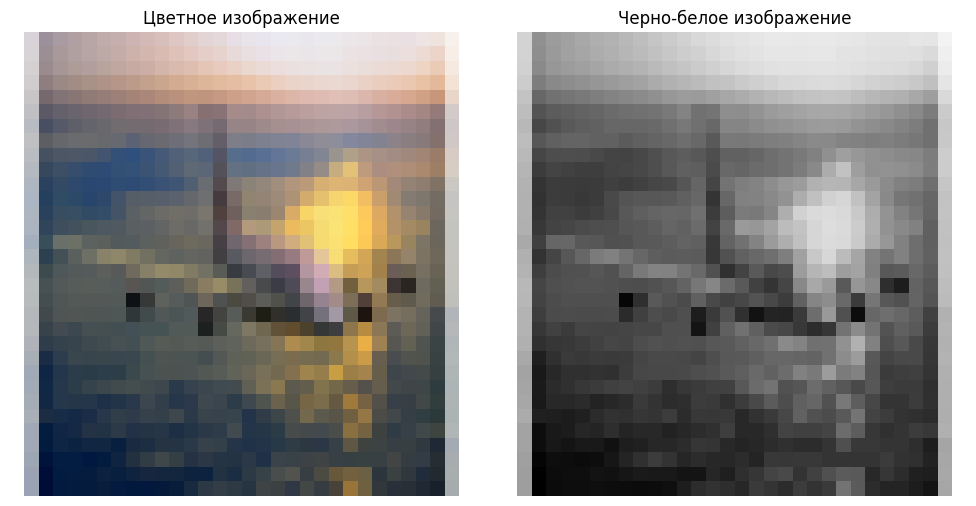

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Модель для цветных изображений предсказывает: airplane
Модель для ЧБ изображений предсказывает: airplane


In [ ]:
# Ввод URL-адресов изображений
urls = []
num_images = int(input("Введите количество изображений: "))
for i in range(num_images):
    url = input(f"Введите URL изображения {i + 1}: ")
    urls.append(url)

# Анализ каждого изображения
for i, url in enumerate(urls):
    print(f"\nАнализ изображения {i + 1}:")
    result = analyze_image(model, model_gray, url)
    print(f"Модель для цветных изображений предсказывает: {result['color']}")
    print(f"Модель для ЧБ изображений предсказывает: {result['gray']}")

# Вывод


В ходе практической работы была успешно создана и обучена нейронная сеть для классификации изображений на два класса: машины и самолеты. Использование датасета CIFAR-10 позволило работать с реальными изображениями.


Реализованная сверточная нейронная сеть продемонстрировала свою эффективность в задачах классификации изображений. CNN автоматически извлекает признаки из данных, что значительно упрощает процесс разработки модели и позволяет достигать высокой точности даже на небольших изображениях размером 32x32 пикселя.


Использование предобученной модели VGG19 для извлечения признаков оказалось полезным подходом. Transfer learning позволил сократить время обучения и улучшить качество модели за счет использования знаний, полученных на большом наборе данных ImageNet. Дополнительные слои, дообученные на данных CIFAR-10, успешно адаптировали модель для решения задачи бинарной классификации.


Для улучшения производительности модели можно рассмотреть использование других архитектур нейронных сетей (например, ResNet или EfficientNet), увеличение размера входных изображений или применение дополнительных методов аугментации данных. Также возможно расширение задачи на большее количество классов из датасета CIFAR-10.
Таким образом, работа демонстрирует успешное применение современных методов глубокого обучения для решения задачи классификации изображений и подчеркивает важность выбора подходящих архитектур и методов для достижения высокой точности.